In [1]:
#Here we gather to learn monte carlo methods
#31012024
#Fabian Jöbstl

import numpy as np
import random
import matplotlib.pyplot as plt


<div>
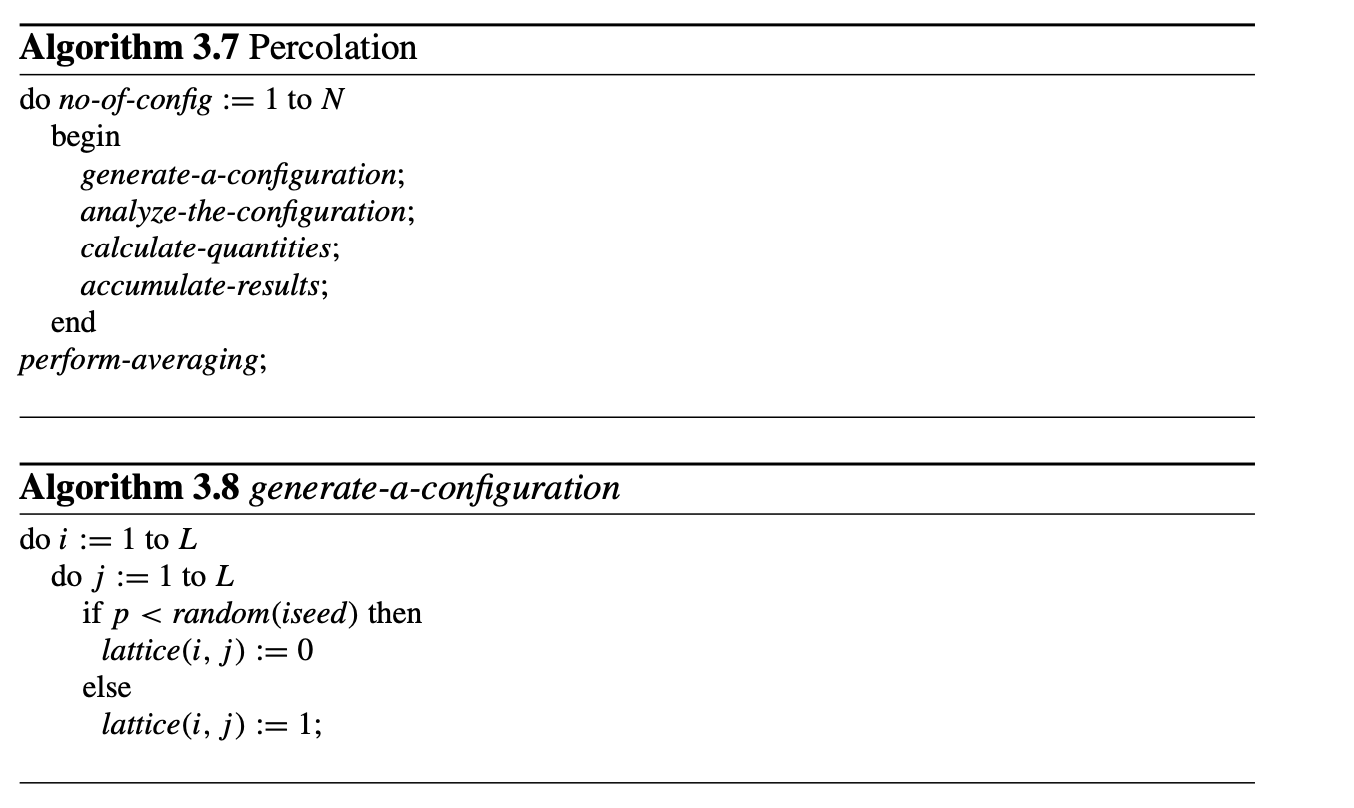
</div>
<div>
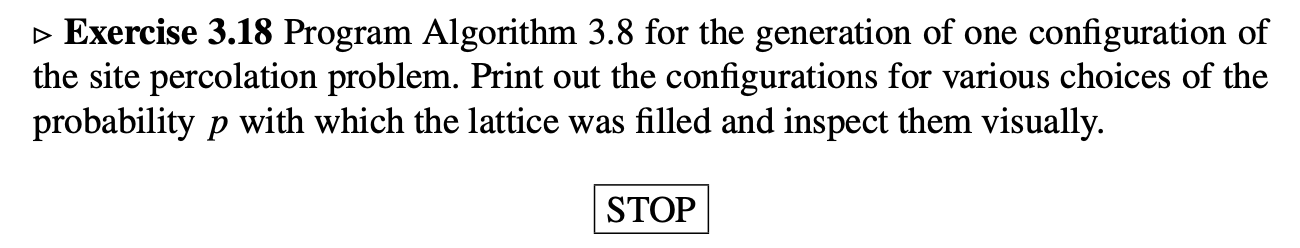
</div>

[[1. 1. 1. 1. 1. 1. 0. 1. 0. 1.]
 [1. 1. 1. 0. 1. 1. 1. 1. 1. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 0. 1. 1. 0. 0. 1. 0. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
 [1. 1. 1. 1. 1. 0. 1. 0. 1. 0.]
 [1. 0. 1. 0. 1. 0. 1. 1. 0. 1.]
 [1. 0. 1. 0. 0. 1. 1. 0. 1. 0.]
 [0. 1. 1. 1. 0. 1. 1. 1. 1. 0.]
 [0. 1. 0. 1. 1. 0. 0. 1. 1. 1.]]


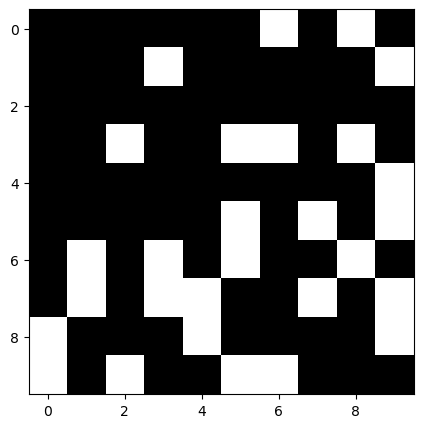

In [2]:
N = 10 #number of configs
L = 10 #size
p = 0.8 #probability
configs = np.arange(1, N+1)
lattice = np.zeros((L, L))
def gen_config(L,p):
    for i in range(0,L):
        for j in range (0,L):
            if p < random.random():
                lattice[i,j]=0
            else: 
                lattice[i,j]=1
    return lattice

config = gen_config(L,p)



print(config)
plt.figure(figsize=(5, 5))
plt.imshow(lattice, cmap='Greys', interpolation='none')
#plt.xticks(np.arange(-.5, L, 1), [])
#plt.yticks(np.arange(-.5, L, 1), [])
#plt.grid(color='black', linestyle='-', linewidth=1)
plt.show()

<div>
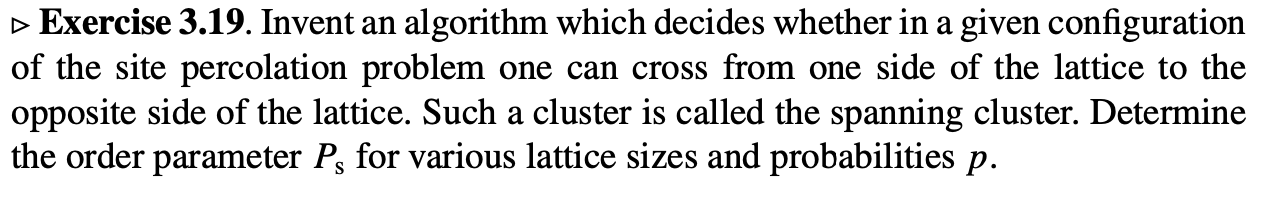
</div>
<div>
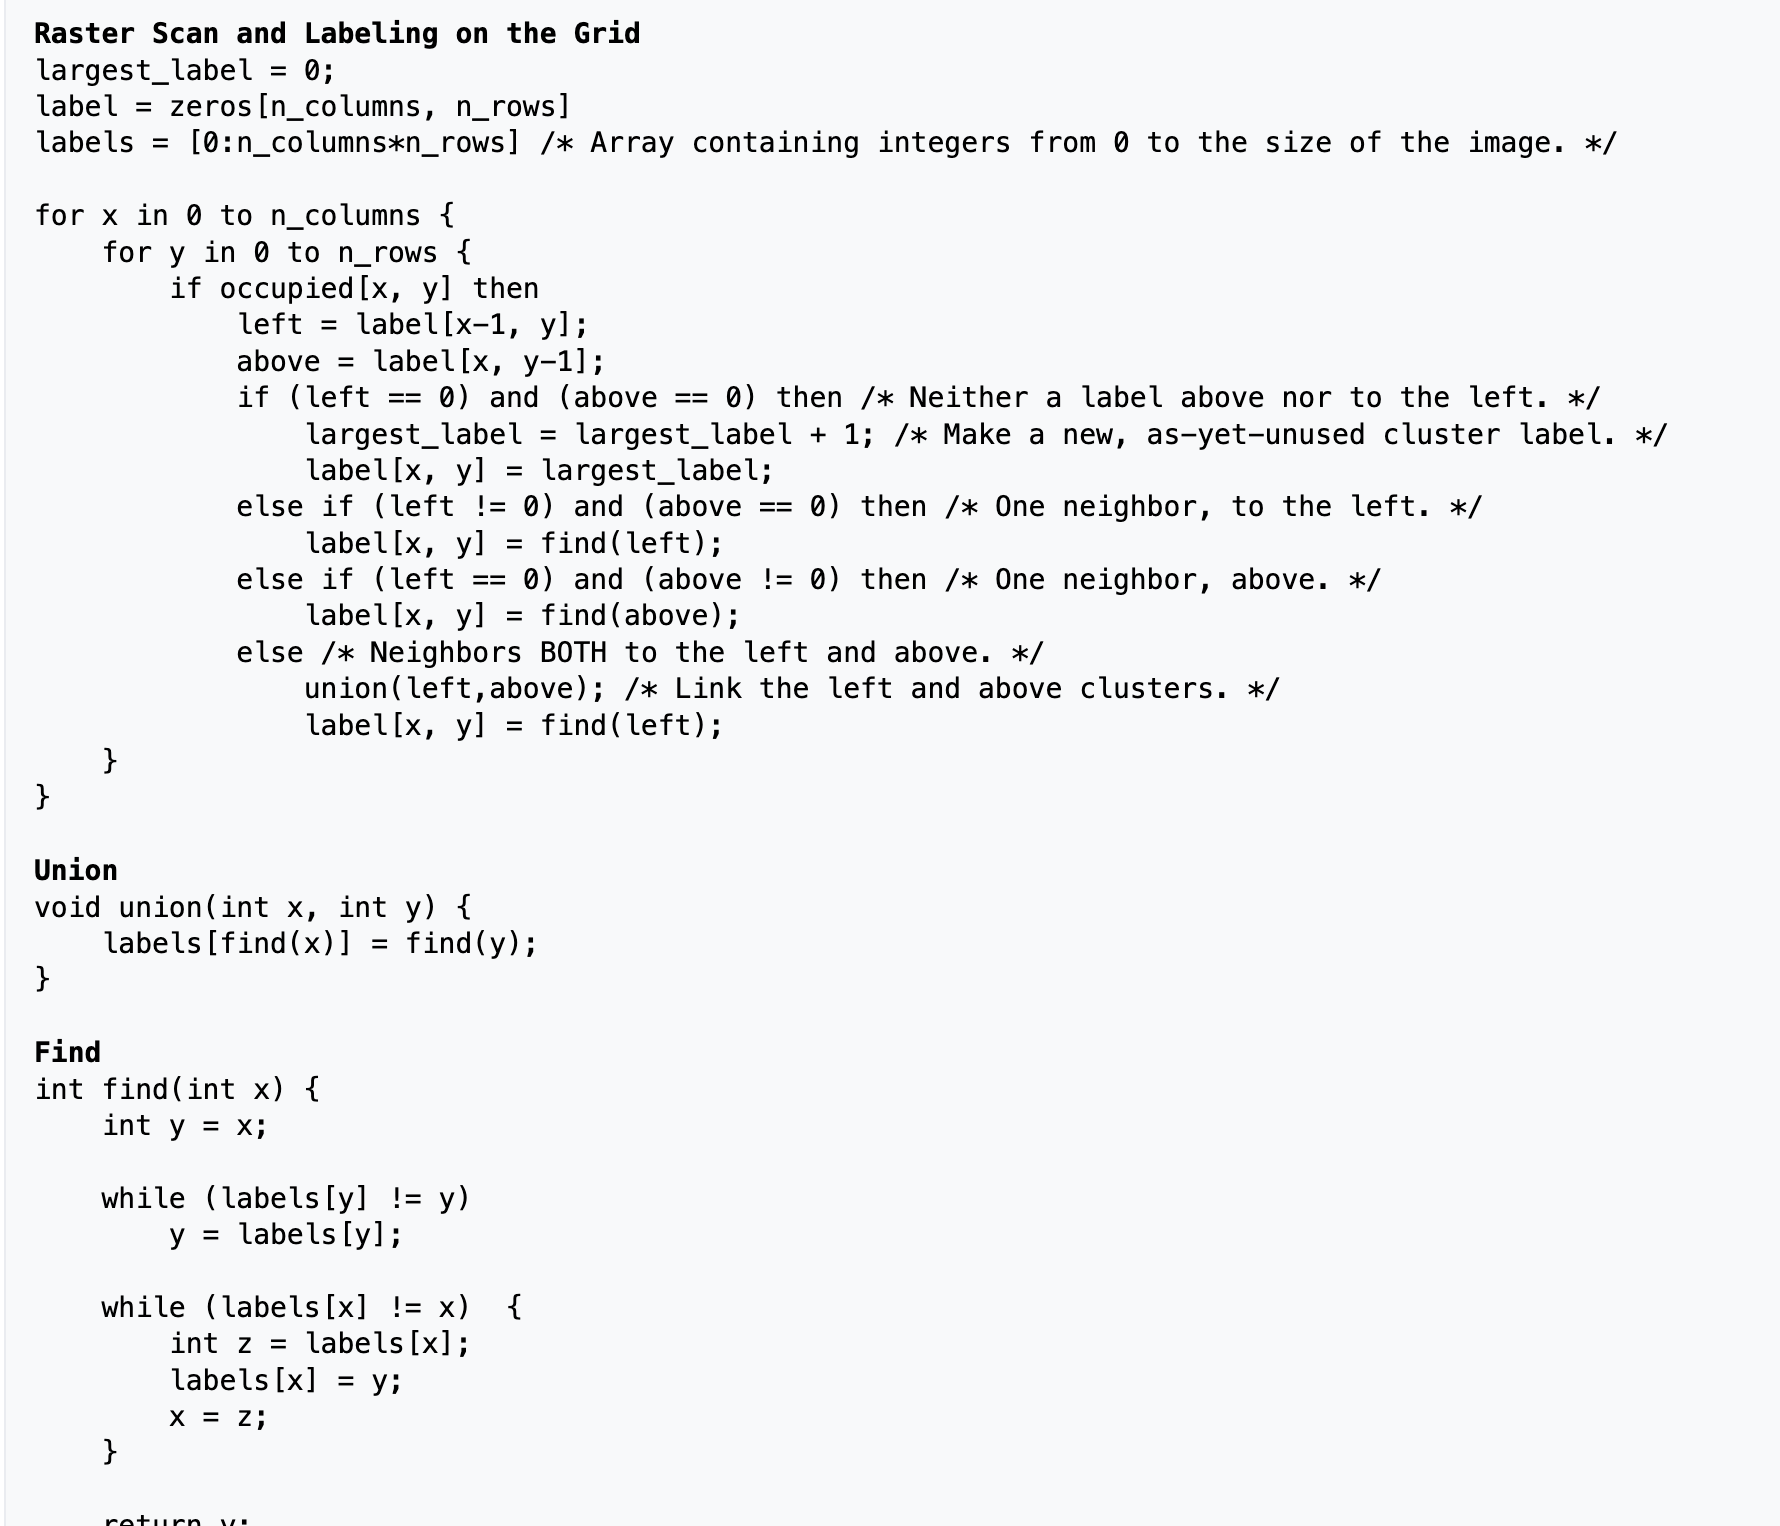
</div>

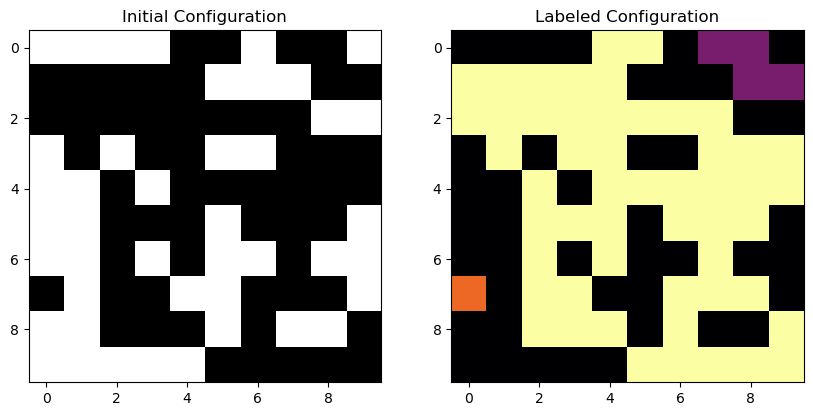

Number of clusters: 3


In [51]:
#Free boundary conditions

import numpy as np
import random
import matplotlib.pyplot as plt

L = 10  # Lattice size
p = 0.5927  # Occupation probability

def gen_config(L, p):
    lattice = np.zeros((L, L))
    for i in range(L):
        for j in range(L):
            lattice[i, j] = 1 if random.random() < p else 0
    return lattice

def find_root(x, labels):
    # Ensure we're working with integer label
    x = int(x)
    while labels[x] != x:
        x = labels[x]
    return x

def union(x, y, labels):
    # Find the roots for x and y and unionize them
    root_x = find_root(int(x), labels)
    root_y = find_root(int(y), labels)
    labels[root_x] = root_y

def hoshen_kopelman(lattice):
    L = lattice.shape[0]
    # Make sure the labels array is large enough to include all possible labels
    labels = np.arange(L*L+1)
    next_label = 1

    # Create an empty array to store labels
    label_lattice = np.zeros_like(lattice)

    for y in range(L):
        for x in range(L):
            if lattice[y, x] == 1:  # If the site is occupied
                up_label = label_lattice[y-1, x] if y > 0 else 0
                left_label = label_lattice[y, x-1] if x > 0 else 0

                min_label = None
                if up_label and left_label:  # Connected to both clusters
                    min_label = min(up_label, left_label)
                    label_lattice[y, x] = min_label
                    if up_label != left_label:
                        union(up_label, left_label, labels) #unify labels when not the same
                elif up_label or left_label:  # Connected to one cluster
                    min_label = up_label or left_label
                    label_lattice[y, x] = min_label
                else:  # New cluster
                    labels[next_label] = next_label
                    label_lattice[y, x] = next_label
                    next_label += 1

                # Update labels array for new connections
                if min_label is not None:
                    for label in (up_label, left_label):
                        if label:
                            union(min_label, label, labels)

    # Second pass to correct labels
    for y in range(L):
        for x in range(L):
            if label_lattice[y, x] > 0:
                label_lattice[y, x] = find_root(label_lattice[y, x], labels)

    # Normalize labels
    unique_labels = np.unique(label_lattice)
    unique_labels = unique_labels[unique_labels != 0]  # Remove zero label
    label_mapping = {old_label: new_label for new_label, old_label in enumerate(unique_labels, start=1)}
    for old_label, new_label in label_mapping.items():
        label_lattice[label_lattice == old_label] = new_label

    return label_lattice, len(unique_labels)

def calculate_P_infinity(L, p, trials):
    """
    Calculate the order parameter P_infinity for a given lattice size L, occupation probability p,
    and number of trials. P_infinity is the size of the largest cluster divided by the total
    number of occupied sites, averaged over all trials.
    """
    largest_clusters = []
    for _ in range(trials):
        config = gen_config(L, p)
        labeled_config, num_clusters = hoshen_kopelman(config)
        # Make sure labeled_config is an array of integers
        labeled_config = labeled_config.astype(np.int64)
        cluster_sizes = np.bincount(labeled_config.flatten())[1:]  # Ignore zero label
        if cluster_sizes.size > 0:
            largest_cluster = np.max(cluster_sizes)
            total_occupied = np.sum(cluster_sizes)
            largest_clusters.append(largest_cluster / total_occupied)
        else:
            largest_clusters.append(0)

    P_infinity = np.mean(largest_clusters)
    return P_infinity




# Generate configuration and apply Hoshen-Kopelman
config0 = gen_config(L, p).astype(np.int32)
labeled_config, num_clusters = hoshen_kopelman(config0)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(config0, cmap='Greys', interpolation='none')
axes[0].set_title('Initial Configuration')
axes[1].imshow(labeled_config, cmap='inferno', interpolation='none')
axes[1].set_title('Labeled Configuration')
plt.show()

print(f"Number of clusters: {num_clusters}")


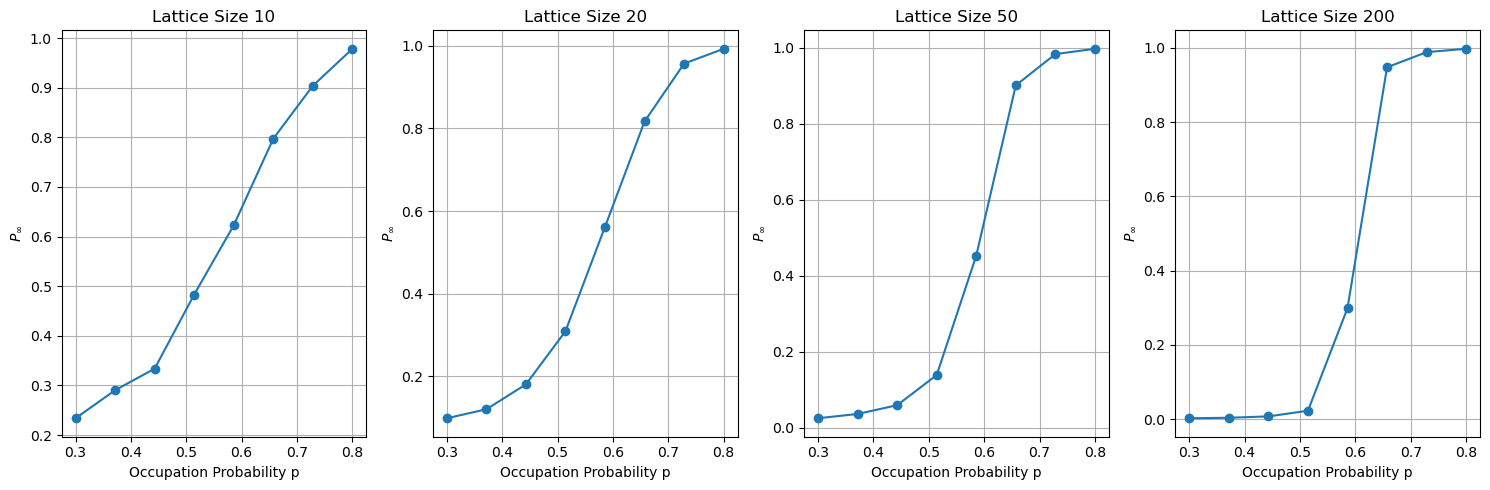

In [54]:
sizes = [10, 20, 50]
probabilities = np.linspace(0.3, 0.8, 8)
trials = 100  # Number of trials for each probability value

# Initialize the plot
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Calculate and plot P_infinity for each lattice size
for i, L in enumerate(sizes):
    P_infinity_values = [calculate_P_infinity(L, p, trials) for p in probabilities]
    axes[i].plot(probabilities, P_infinity_values, marker='o')
    axes[i].set_title(f'Lattice Size {L}')
    axes[i].set_xlabel('Occupation Probability p')
    axes[i].set_ylabel('$P_{\infty}$')
    axes[i].grid(True)

# Adjust the layout
plt.tight_layout()
plt.show()

#This shows finite size effects of the order parameter!!

In [ ]:
#Periodic boundary conditions, but not yet 

import numpy as np
import random
import matplotlib.pyplot as plt

L = 10  # Lattice size
p = 0.7  # Occupation probability

def gen_config(L, p):
    lattice = np.zeros((L, L))
    for i in range(L):
        for j in range(L):
            lattice[i, j] = 1 if random.random() < p else 0
    return lattice

def find_root(x, labels):
    y = x
    while labels[y] != y:
        y = labels[y]
    while labels[x] != x:
        z = labels[x]
        labels[x] = y
        x = z
    return y

def union(x, y, labels):
    labels[find_root(x, labels)] = find_root(y, labels)

def hoshen_kopelman(lattice):
    L = lattice.shape[0]
    labels = np.zeros(L*L, dtype=int)
    next_label = 1

    # Create an empty array to store labels
    label_lattice = np.zeros_like(lattice)

    for y in range(L):
        for x in range(L):
            if lattice[y, x] == 1:  # If the site is occupied
                up_label = label_lattice[y-1, x] if y > 0 else 0
                left_label = label_lattice[y, x-1] if x > 0 else 0

                min_label = None
                if up_label and left_label:  # Connected to both clusters
                    min_label = min(up_label, left_label)
                    label_lattice[y, x] = min_label
                    if up_label != left_label:
                        union(up_label, left_label, labels)
                elif up_label or left_label:  # Connected to one cluster
                    min_label = up_label or left_label
                    label_lattice[y, x] = min_label
                else:  # New cluster
                    labels[next_label] = next_label
                    label_lattice[y, x] = next_label
                    next_label += 1

                # Update labels array for new connections
                if min_label is not None:
                    for label in (up_label, left_label):
                        if label:
                            union(min_label, label, labels)

    # Second pass to correct labels
    for y in range(L):
        for x in range(L):
            if label_lattice[y, x] > 0:
                label_lattice[y, x] = find_root(label_lattice[y, x], labels)

    # Normalize labels
    unique_labels = np.unique(label_lattice)
    unique_labels = unique_labels[unique_labels != 0]  # Remove zero label
    label_mapping = {old_label: new_label for new_label, old_label in enumerate(unique_labels, start=1)}
    for old_label, new_label in label_mapping.items():
        label_lattice[label_lattice == old_label] = new_label

    return label_lattice, len(unique_labels)




# Generate configuration and apply Hoshen-Kopelman
config0 = gen_config(L, p).astype(np.int32)
labeled_config, num_clusters = hoshen_kopelman(config0)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(config0, cmap='Greys', interpolation='none')
axes[0].set_title('Initial Configuration')
axes[1].imshow(labeled_config, cmap='inferno', interpolation='none')
axes[1].set_title('Labeled Configuration')
plt.show()

print(f"Number of clusters: {num_clusters}")


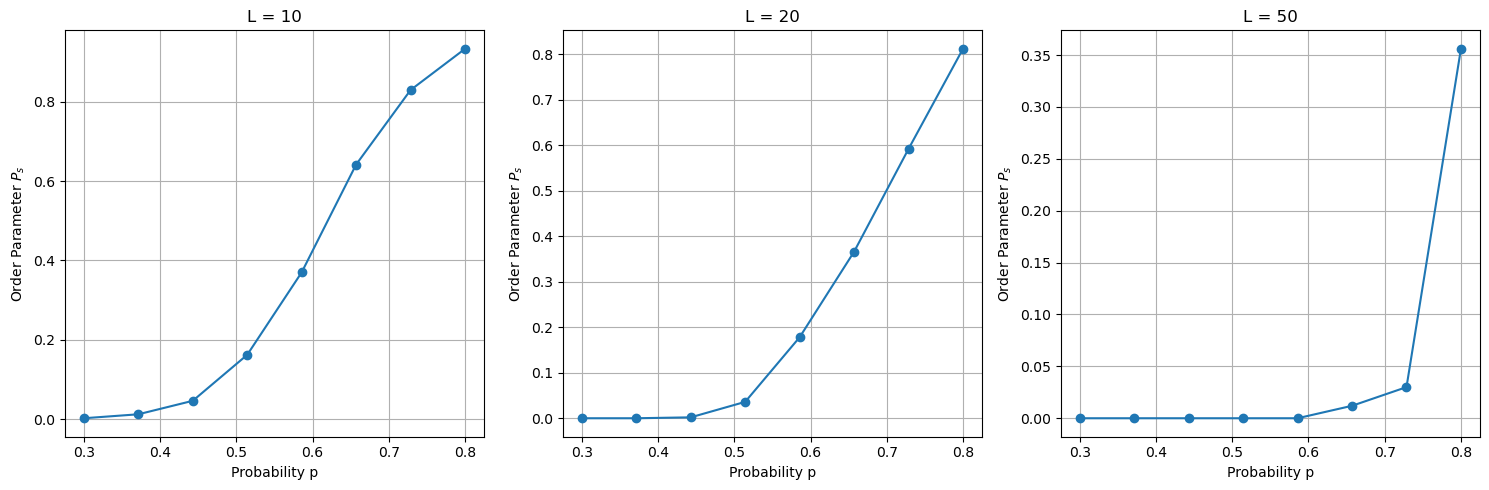

In [34]:
#Calculation of order parameter P_s

def gen_config(L, p):
    """Generate a site percolation lattice configuration."""
    return np.random.choice([0, 1], size=(L, L), p=[1-p, p])

def hoshen_kopelman(lattice):
    """Apply the Hoshen-Kopelman algorithm and identify if a spanning cluster exists."""
    L = lattice.shape[0]
    labels = np.arange(L*L+1)
    label = 1
    label_lattice = np.zeros_like(lattice, dtype=int)
    top_labels = set()
    bottom_labels = set()

    for y in range(L):
        for x in range(L):
            if lattice[y, x] == 1:
                neighbors = []
                if x > 0 and label_lattice[y, x-1] > 0:
                    neighbors.append(label_lattice[y, x-1])
                if y > 0 and label_lattice[y-1, x] > 0:
                    neighbors.append(label_lattice[y-1, x])

                min_label = min(neighbors) if neighbors else label
                label_lattice[y, x] = min_label
                for neighbor in neighbors:
                    if neighbor != min_label:
                        root_min = find_root(min_label, labels)
                        root_neighbor = find_root(neighbor, labels)
                        labels[root_neighbor] = root_min

                if not neighbors:
                    label += 1

                if y == 0:
                    top_labels.add(find_root(min_label, labels))
                elif y == L-1:
                    bottom_labels.add(find_root(min_label, labels))

    spanning_labels = top_labels.intersection(bottom_labels)
    spanning = bool(spanning_labels)

    return spanning, label_lattice

def find_root(x, labels):
    """Find the root of x."""
    while x != labels[x]:
        x = labels[x]
    return x

def calculate_Ps(L, probabilities, N=500):
    """Calculate the order parameter Ps for a given L and range of probabilities."""
    Ps_values = []
    for p in probabilities:
        spanning_count = 0
        for _ in range(N):
            lattice = gen_config(L, p)
            spanning, _ = hoshen_kopelman(lattice)
            if spanning:
                spanning_count += 1
        Ps_values.append(spanning_count / N)
    return Ps_values

# Lattice sizes and probabilities
sizes = [10, 20, 50]
probabilities = np.linspace(0.3, 0.8, 8)
results = {}

# Calculate Ps for each lattice size
for L in sizes:
    results[L] = calculate_Ps(L, probabilities)

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, L in enumerate(sizes):
    axes[i].plot(probabilities, results[L], marker='o', linestyle='-')
    axes[i].set_title(f'L = {L}')
    axes[i].set_xlabel('Probability p')
    axes[i].set_ylabel('Order Parameter $P_s$')
    axes[i].grid(True)

plt.tight_layout()
plt.show()
#This shows finite size effects of the order parameter!!

<div>
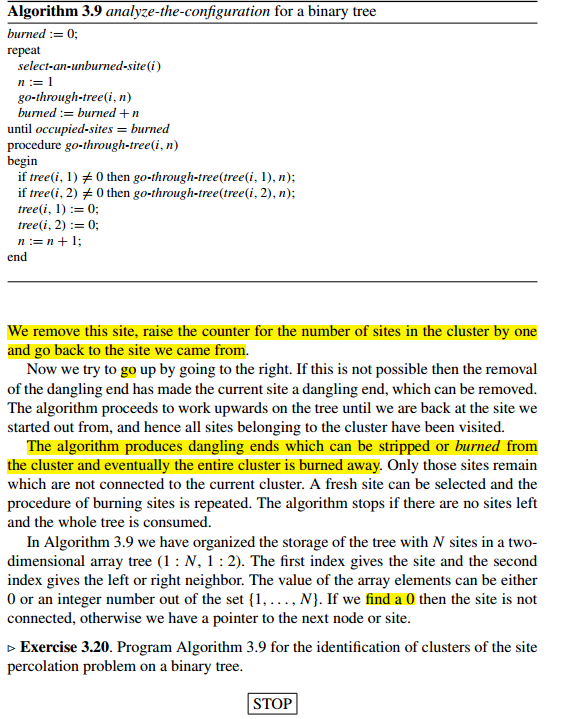
</div>

In [16]:
import numpy as np

class BinaryTreeClusterAnalysis:
    def __init__(self, N):
        self.N = N  # Store the number of sites
        self.tree = np.zeros((N, 2), dtype=int)  # Initialize the tree array
        self.burned = 0  # Initialize the burned sites count
        self.occupied_sites = 0  # Initialize the occupied sites count
        self.populate_tree()  # Populate the tree with some values

    def populate_tree(self):
        # Example of how to populate the tree
        for i in range(self.N):
            if np.random.rand() < 0.4:  # Randomly decide if a site is occupied
                self.tree[i] = [np.random.randint(1, self.N), np.random.randint(1, self.N)]
                self.occupied_sites += 1

    def select_unburned_site(self):
        # Find the index of the first unburned site
        for i, (left, right) in enumerate(self.tree):
            if left != 0 or right != 0:
                return i
        return -1  # If all sites are burned

    def go_through_tree(self, i, n):
        # Recursively go through the tree to burn the cluster
        if self.tree[i, 0] != 0:  # Check the left child
            n = self.go_through_tree(self.tree[i, 0], n)
        if self.tree[i, 1] != 0:  # Check the right child
            n = self.go_through_tree(self.tree[i, 1], n)
        self.tree[i] = [0, 0]  # Burn the current site
        n += 1  # Increment the counter for the cluster size
        return n

    def analyze_the_configuration(self):
        while self.occupied_sites != self.burned:
            i = self.select_unburned_site()
            if i == -1:  # No unburned sites left
                break
            n = 1  # Initialize the cluster size
            n = self.go_through_tree(i, n)  # Burn the cluster
            self.burned += n  # Update the burned sites count
            print(f"Burned a cluster of size {n}")
        print("All clusters have been burned.")

# Example usage:
N = 15  # Number of sites
analysis = BinaryTreeClusterAnalysis(N)
analysis.analyze_the_configuration()


Burned a cluster of size 4
Burned a cluster of size 4
All clusters have been burned.


In [10]:


# Python program to explain sys.setrecursionlimit() method  
      
# Importing sys module  
import sys  
  
# Using sys.getrecursionlimit() method  
# to find the current recursion limit 
limit = sys.getrecursionlimit() 
  
# Print the current limit  
print('Before changing, limit of stack =', limit)  
  
# New limit 
Newlimit = 20000
  
# Using sys.setrecursionlimit() method  
sys.setrecursionlimit(Newlimit)  
  
# Using sys.getrecursionlimit() method  
# to find the current recursion limit 
limit = sys.getrecursionlimit() 
  
# Print the current limit  
print('After changing, limit of stack =', limit)  
  

Before changing, limit of stack = 10000
After changing, limit of stack = 20000
